In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
path = "/Users/atalianb/Documents/data_LBSG/Blok_McGaugh_& _Rubin_(2001)/"

In [3]:
##Values for epsilon and the field mass from the chi^2,
##taking just l=0 or l=1 for the data set ESO3020120
####
eps_l0 = 3.8e-4
eps_l1 = 3.7e-4
m_a_l0 = 6.2e-24#eV/c^2
m_a_l1 = 8.8e-24#eV/c^2
#####Gravitational Constant
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10.# End of integration
step_0 = 0.5#Step to integrate from x0_0 until xf_0v1 is reached
##l=0
u1_0 = 0.63173215# 1st trial value of unknown init. cond.
u2_0 = 1.28125868# 2nd trial value of unknown init. cond.
u_0 = np.array([u1_0, u2_0])
###l=1 
u1_1 = -3.7# 1st trial value of unknown init. cond.
u2_1 = -2.2# 2nd trial value of unknown init. cond.
u_1 = np.array([u1_1, u2_1])

In [4]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [5]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        x_list.append(x)
        root = optimize.root(res,u)
        u = root.x
        root_temp = optimize.root(res,root.x)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [6]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [7]:
def f0(x,y):
    l = 0.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F
def f1(x,y):
    l = 1.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [8]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [9]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [10]:
#The function integrate f for the l of your choise with the shooting method,
#taking s_begin as the initial array for the shooting method.
#integrates to find the M(r) and returns the r[kpc] and Vc[km/s] 
#if the last element of r[kpc] array is minor than the last element of the r data array
#takes the last element of the M(r) array and compute the Vc^2 for the rest of the r elements
def Vc_xy(r,m_a,eps,func,s_begin,l):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(func,s_begin,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [11]:
def Vc_xi2(r,m_a,eps,func,u_begin,l):
    Vc = Vc_xy(r,m_a,eps,func,u_begin,l)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

In [12]:
ESO3020120 = np.loadtxt(path+'ESO3020120.dat')

In [13]:
vecRp_ESO3020120 = np.array([row[1] for row in ESO3020120])# galactocentric distance [kpc]
vecvRp_ESO3020120 = np.array([row[5] for row in ESO3020120])# rotation velocity [km/s]
vecerrvRp_ESO3020120 = np.array([row[6] for row in ESO3020120])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

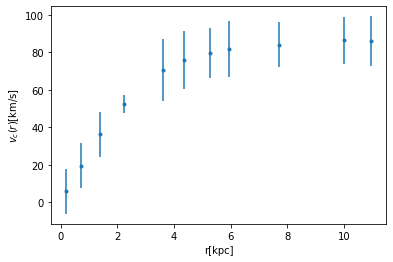

In [14]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$\epsilon$ and $m_{a, \ell = 0}$

In [18]:
def Vc_tot_eps_l0(r,param):
    eps = param
    Vc2 = Vc_xi2(r,m_a_l0,eps,f0,u_0,l=0.) + Vc_xi2(r,m_a_l0,eps,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [19]:
def Xi2_eps_l0_ESO3020120(param):
    eps = np.exp(param)
    model = Vc_tot_eps_l0(vecRp_ESO3020120,eps)
    xi = np.sum((vecvRp_ESO3020120)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [33]:
x0_eps_l0_ESO3020120 = np.array(np.log(9.0e-4))
LS_eps_l0_ESO3020120 = optimize.minimize(Xi2_eps_l0_ESO3020120,x0_eps_l0_ESO3020120,method='TNC',bounds=((np.log(1.0e-4),np.log(9.0e-4)),))
print(LS_eps_l0_ESO3020120)

     fun: 379.3836816170932
     jac: array([-0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 2
     nit: 0
  status: 0
 success: True
       x: array([-7.01311579])


In [34]:
np.exp(LS_eps_l0_ESO3020120.x)

array([0.0009])

# Grid

In [51]:
eps_array = np.linspace(np.log(1.0e-4),np.log(9.0e-4),50)

In [52]:
Chi_eps_array = np.zeros(len(eps_array))
for i in range(0,len(eps_array)):
    param = np.array(eps_array[i])
    Chi_eps_array[i] = Xi2_eps_l0_ESO3020120(param)

(379.0, 380.0)

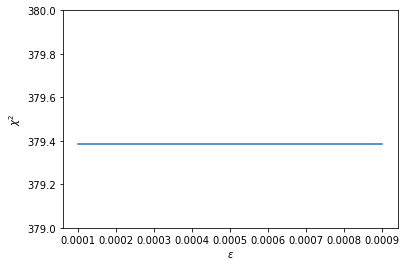

In [53]:
plt.plot(np.exp(eps_array),Chi_eps_array)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\chi^{2}$')
plt.ylim(379,380)

$\epsilon$ and $m_{a,\ell=1}$

In [54]:
def Vc_tot_eps_l1(r,param):
    eps = param
    Vc2 = Vc_xi2(r,m_a_l1,eps,f0,u_0,l=0.) + Vc_xi2(r,m_a_l1,eps,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [55]:
def Xi2_eps_l1_ESO3020120(param):
    eps = np.exp(param)
    model = Vc_tot_eps_l1(vecRp_ESO3020120,eps)
    xi = np.sum((vecvRp_ESO3020120)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [65]:
x0_eps_l1_ESO3020120 = np.array(np.log(5.0e-4))
LS_eps_l1_ESO3020120 = optimize.minimize(Xi2_eps_l1_ESO3020120,x0_eps_l1_ESO3020120,method='TNC',bounds=((np.log(1.0e-4),np.log(9.0e-4)),))
print(LS_eps_l1_ESO3020120)

     fun: 379.3836816170932
     jac: array([0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 2
     nit: 0
  status: 0
 success: True
       x: array([-7.60090246])


In [66]:
np.exp(LS_eps_l1_ESO3020120.x)

array([0.0005])

In [67]:
Chi_eps_l1_array = np.zeros(len(eps_array))
for i in range(0,len(eps_array)):
    param = np.array(eps_array[i])
    Chi_eps_l1_array[i] = Xi2_eps_l1_ESO3020120(param)

(379.0, 380.0)

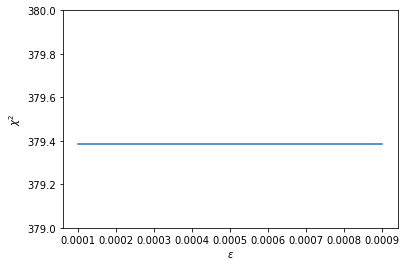

In [68]:
plt.plot(np.exp(eps_array),Chi_eps_l1_array)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\chi^{2}$')
plt.ylim(379,380)

# diferent $\epsilon$ for each $\ell$

In [69]:
def Vc_tot_eps_l0_l1_m0(r,params):
    eps0,eps1 = params
    Vc2 = Vc_xi2(r,m_a_l0,eps0,f0,u_0,l=0.) + Vc_xi2(r,m_a_l0,eps1,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [70]:
def Xi2_eps_l0_l1_m0_ESO3020120(params):
    eps0,eps1 = params
    par = np.exp(eps0),np.exp(eps1)
    model = Vc_tot_eps_l0_l1_m0(vecRp_ESO3020120,par)
    xi = np.sum((vecvRp_ESO3020120)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [71]:
x0_eps_l0_l1_m0_ESO3020120 = np.array([np.log(5.0e-4),np.log(5.0e-4)])
LS_eps_l0_l1_m0_ESO3020120 = optimize.minimize(Xi2_eps_l0_l1_m0_ESO3020120,x0_eps_l0_l1_m0_ESO3020120,method='TNC',bounds=((np.log(1.0e-4),np.log(9.0e-4)),(np.log(1.0e-4),np.log(9.0e-4)),))
print(LS_eps_l0_l1_m0_ESO3020120)

     fun: 379.3836816170932
     jac: array([0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 3
     nit: 0
  status: 0
 success: True
       x: array([-7.60090246, -7.60090246])


In [72]:
np.exp(LS_eps_l0_l1_m0_ESO3020120.x)

array([0.0005, 0.0005])

In [73]:
eps0_array = np.linspace(np.log(1.0e-4),np.log(9.0e-4),10)
eps1_array = np.linspace(np.log(1.0e-4),np.log(9.0e-4),10)

In [74]:
Z = np.zeros((len(eps0_array), len(eps1_array)))
for i in range(0,len(eps0_array)):
    for j in range(0,len(eps1_array)):
        parameters = np.array([eps0_array[i],eps1_array[j]])
        Z[j,i] = Xi2_eps_l0_l1_m0_ESO3020120(parameters)

In [75]:
Eps0_grid,Eps1_grid = np.meshgrid(eps0_array,eps1_array)

Text(0.5, 0, '$\\chi^{2}$')

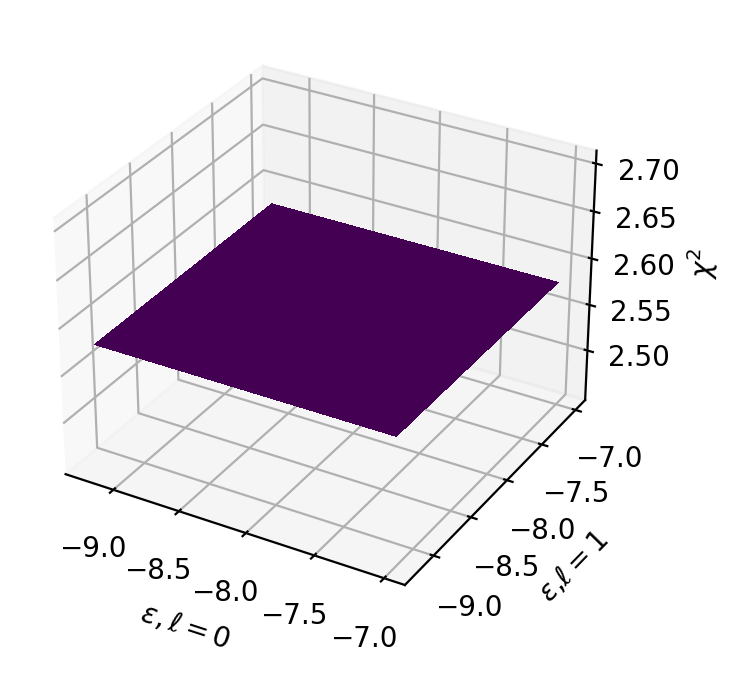

In [77]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=200)
# Plot the surface.
surf = ax.plot_surface(Eps0_grid,Eps1_grid,np.log10(Z),cmap='viridis',linewidth=0,antialiased=False)
ax.set_xlabel(r'$\epsilon, \ell=0$')
ax.set_ylabel(r'$\epsilon$,$\ell=1$')
ax.set_zlabel(r'$\chi^{2}$')

# $m_{a}$

In [78]:
def Vc_tot_m_a(r,param):
    m_a = param
    Vc2 = Vc_xi2(r,m_a,eps_l0,f0,u_0,l=0.) + Vc_xi2(r,m_a,eps_l0,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [79]:
def Xi2_m_a_ESO3020120(param):
    m_a = np.exp(param)
    model = Vc_tot_m_a(vecRp_ESO3020120,m_a)
    xi = np.sum((vecvRp_ESO3020120)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [84]:
x0_m_a_ESO3020120 = np.array(np.log(5.0e-24))
LS_m_a_ESO3020120 = optimize.minimize(Xi2_m_a_ESO3020120,x0_m_a_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(9.0e-24)),))
print(LS_m_a_ESO3020120)

      fun: 379.3836816170932
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-53.65260432])


In [85]:
np.exp(LS_m_a_ESO3020120.x)

array([5.e-24])

# Fixing $\phi_{0,\ell = 1}$ = (0.01,1)

In [86]:
def rescaling(phi_0,l):
    lmbd = (1./phi_0)**(1/(l+2.))
    return lmbd

In [243]:
def Vc_xy_phi(r,m_a,eps,phi0,func,s_begin,l):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(func,s_begin,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    Xl = X0*rescaling(phi0,l)
    M_r0 = Mass_func(Xl,Y0*phi0,l)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(Xl,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(Xl,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,Vc2_total
    else:
        return X0_units,Vc2_r0

In [244]:
def Vc_xi2_phi(r,m_a,eps,phi0,func,u_begin,l):
    Vc = Vc_xy_phi(r,m_a,eps,phi0,func,u_begin,l)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

In [213]:
phi0_1 = 0.01

In [245]:
def Vc_m_a_eps_phi0(r,params,phi0_1):
    m_a,eps = params
    Vc2 = Vc_xi2_phi(r,m_a,eps,1.,f0,u_0,l=0.) + Vc_xi2_phi(r,m_a,eps,phi0_1,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [227]:
def Xi2_m_a_eps_ESO3020120(params,phi0):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_m_a_eps_phi0(vecRp_ESO3020120,par,phi0)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [114]:
x0_m_a_eps_ESO3020120 = np.array([np.log(5.0e-24),np.log(1.0e-4)])
LS_m_a_eps_ESO3020120 = optimize.minimize(Xi2_m_a_eps_ESO3020120,x0_m_a_eps_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(9.0e-24)),(np.log(1.0e-5),np.log(1.)),),args=(phi0_1))
print(LS_m_a_eps_ESO3020120)

      fun: 82.72581769939458
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.17358174e+01, -1.49213975e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 12
     njev: 21
   status: 0
  success: True
        x: array([-55.26204223,  -4.34978843])


In [115]:
np.exp(LS_m_a_eps_ESO3020120.x)

array([1.00000000e-24, 1.29095435e-02])

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


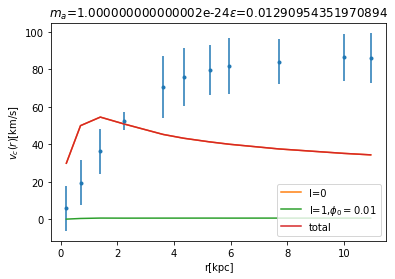

In [116]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1])),1.,f0,u_0,l=0.)),label='l=0')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1])),phi0_1,f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_1))
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0(vecRp_ESO3020120,np.exp(LS_m_a_eps_ESO3020120.x),phi0_1),label='total')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_ESO3020120.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_ESO3020120.x[1])))
plt.legend(loc='lower right')

In [121]:
for i in np.arange(0.,1.,0.2):
    print(i)

0.0
0.2
0.4
0.6000000000000001
0.8


In [119]:
chi_vals = []
for i in np.arange(0.,1.,0.01):
    x0_m_a_eps_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
    LS_m_a_eps_ESO3020120 = optimize.minimize(Xi2_m_a_eps_ESO3020120,x0_m_a_eps_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.)),),args=(i))
    chi_vals.append(LS_m_a_eps_ESO3020120.x)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWa

KeyboardInterrupt: 

# Grid with $\phi_{0,\ell = 0}$ and $\phi_{0,\ell =1}$

In [246]:
def Vc_m_a_eps_phi0_01(r,params,phi0_0,phi0_1):
    m_a,eps0,eps1 = params
    Vc2 = Vc_xi2_phi(r,m_a,eps0,phi0_0,f0,u_0,l=0.) + Vc_xi2_phi(r,m_a,eps1,phi0_1,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [247]:
def Xi2_m_a_eps_phi01_ESO3020120(params,phi00,phi01):
    m_a,eps0,eps1 = params
    par = np.exp(m_a),np.exp(eps0),np.exp(eps1)
    model = Vc_m_a_eps_phi0_01(vecRp_ESO3020120,par,phi00,phi01)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [131]:
phi0_array = np.arange(0.01,1.,0.2)
test = np.zeros((len(phi0_array),len(phi0_array),2))
for i in range(len(phi0_array)):
    for j in range(len(phi0_array)):
        test[i,j,:] = np.array([phi0_array[i],phi0_array[j]])

In [133]:
np.shape(test)

(5, 5, 2)

In [ ]:
np.savetxt('Chi2'+str(args.data)+'.dat',np.exp(test.reshape((3,-1))),header=str(chi2_.shape))

In [165]:
phi0_array = np.arange(0.01,1.,0.35)

In [258]:
phi0_array

array([0.01, 0.36, 0.71])

In [194]:
x0_m_a_eps_phi0_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4),np.log(1.0e-4)])
LS_m_a_eps_phi0_ESO3020120 = optimize.minimize(Xi2_m_a_eps_phi01_ESO3020120,x0_m_a_eps_phi0_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-25),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.)),(np.log(1.0e-5),np.log(1.)),),args=(phi0_array[0],phi0_array[1]))
print(LS_m_a_eps_phi0_ESO3020120)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


      fun: 140.87967072935675
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.68302052e+00, -2.10320632e-04,  2.03231708e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 296
      nit: 12
     njev: 74
   status: 0
  success: True
        x: array([-53.037406  ,  -9.19602322,  -1.85679161])


In [176]:
test_1 = []
test_1.append(LS_m_a_eps_phi0_ESO3020120.success)

In [177]:
test_1

[True]

In [195]:
np.exp(LS_m_a_eps_phi0_ESO3020120.x)

array([9.25011730e-24, 1.01442013e-04, 1.56172891e-01])

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


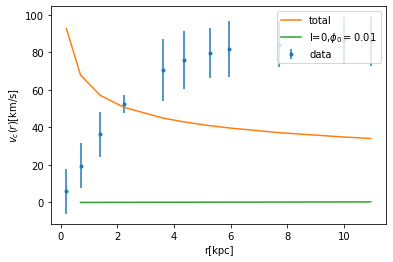

In [240]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0_01(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x),phi0_array[0],phi0_array[1]),label='total')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(np.asscalar(LS_m_a_eps_phi0_ESO3020120.x[0])),np.exp(np.asscalar(LS_m_a_eps_phi0_ESO3020120.x[1])),phi0_array[0],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[0]))
#plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(np.asscalar(LS_m_a_eps_phi0_ESO3020120.x[0])),np.exp(np.asscalar(LS_m_a_eps_phi0_ESO3020120.x[2])),phi0_array[1],f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_array[1]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='upper right')

In [219]:
r_test = np.linspace(vecRp_ESO3020120[0],vecRp_ESO3020120[-1],30)

In [248]:
Vc_test = Vc_xy_phi(r_test,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[2]),phi0_array[1],f1,u_1,l=1.)

In [266]:
np.shape(Vc_test)

(2, 1081)

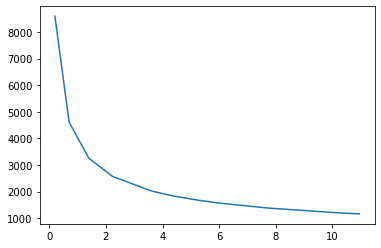

In [274]:
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[2]),phi0_array[1],f1,u_1,l=1.)))
#plt.plot(Vc_test[0],np.sqrt(Vc_test[1]))

In [250]:
Vc_test0 = Vc_xy_phi(r_test,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[1]),phi0_array[0],f0,u_0,l=0.)

In [267]:
np.shape(Vc_test0)

(2, 1001)

In [259]:
mask = Vc_test0[0] <= vecRp_ESO3020120[-1]

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


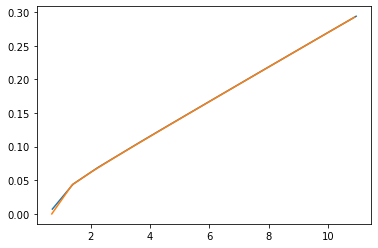

In [261]:
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[1]),phi0_array[0],f0,u_0,l=0.)))
plt.plot(Vc_test0[0][mask],np.sqrt(Vc_test0[1][mask]))

In [268]:
Vc2_l0 = Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[1]),phi0_array[0],f0,u_0,l=0.)

In [269]:
len(Vc2_l0)

11

In [270]:
Vc2_l1 = Vc_xi2_phi(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]),np.exp(LS_m_a_eps_phi0_ESO3020120.x[2]),phi0_array[1],f1,u_1,l=1.)

In [271]:
len(Vc2_l1)

11

In [272]:
vctot_test = np.sqrt(Vc2_l0+Vc2_l1)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


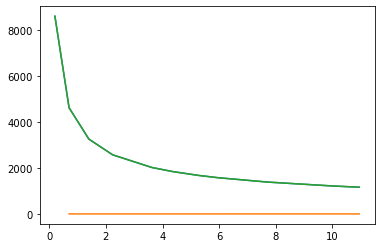

In [276]:
plt.plot(vecRp_ESO3020120,vctot_test)
plt.plot(vecRp_ESO3020120,np.sqrt(Vc2_l0))
plt.plot(vecRp_ESO3020120,np.sqrt(Vc2_l1))

In [142]:
chi2_vals = np.zeros((len(phi0_array),len(phi0_array),2))
for i in range(len(phi0_array)):
    for j in range(len(phi0_array)):
        x0_m_a_eps_phi0_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
        LS_m_a_eps_phi0_ESO3020120 = optimize.minimize(Xi2_m_a_eps_phi01_ESO3020120,x0_m_a_eps_phi0_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.)),),args=(phi0_array[i],phi0_array[j]))
        chi2_vals[i,j,:] = LS_m_a_eps_phi0_ESO3020120.x

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [144]:
np.exp(chi2_vals)

array([[[1.00000000e-23, 1.00000000e-04],
        [1.00000000e-23, 1.00000000e-04],
        [1.00000000e-23, 1.00000000e-04]],

       [[1.00000000e-23, 1.00000000e-04],
        [1.00000000e-24, 1.59331307e-02],
        [1.00000000e-24, 1.23576579e-02]],

       [[1.00000000e-23, 1.00000000e-04],
        [1.00000000e-24, 1.13171384e-02],
        [1.00000000e-24, 8.97501046e-03]]])

In [145]:
phi0_array

array([0.  , 0.35, 0.7 ])

In [152]:
np.exp(chi2_vals[1][1][0])

1.000000000000002e-24

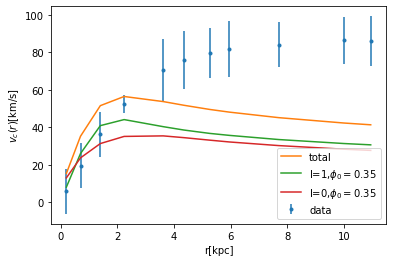

In [155]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0_01(vecRp_ESO3020120,np.exp(chi2_vals[1][1]),phi0_array[1],phi0_array[1]),label='total')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(chi2_vals[1][1][0]),np.exp(chi2_vals[1][1][1]),phi0_array[1],f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_array[1]))
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2_phi(vecRp_ESO3020120,np.exp(chi2_vals[1][1][0]),np.exp(chi2_vals[1][1][1]),phi0_array[1],f0,u_0,l=0.)),label='l=0,'r'$\phi_{0}=$'+str(phi0_array[1]))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.legend(loc='lower right')

In [ ]:
    plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
    plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1])),phi0_1,f0,u_0,l=0.)),label='l=0')
    plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1])),,f1,u_1,l=1.)),label='l=1,'r'$\phi_{0}=$'+str(phi0_1))
    plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0(vecRp_ESO3020120,np.exp(LS_m_a_eps_ESO3020120.x),i),label='total')
    plt.ylabel(r'$v_{c}(r)$[km/s]')
    plt.xlabel("r[kpc]")
    plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_ESO3020120.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_ESO3020120.x[1])))
    plt.legend(loc='lower right')
    plt.savefig('.pdf')

In [278]:
vals_test = np.zeros((len(phi0_array),len(phi0_array),3))
for i in range(len(phi0_array)):
    for j in range(len(phi0_array)):
        vals_test[i,j,:] = np.array([1.,3.,4.]) 

In [280]:
vals_test.reshape((3,-1))

array([[1., 3., 4., 1., 3., 4., 1., 3., 4.],
       [1., 3., 4., 1., 3., 4., 1., 3., 4.],
       [1., 3., 4., 1., 3., 4., 1., 3., 4.]])